# Feature Selection:
## How to Throw Away 95% of Your Data and Get 95% Accuracy
https://towardsdatascience.com/feature-selection-how-to-throw-away-95-of-your-data-and-get-95-accuracy-ad41ca016877

In [1]:
# Use all processor cores
from sklearnex import patch_sklearn
patch_sklearn()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load Libraries
import pandas as pd
import numpy as np

### Load Data

In [3]:
# Load data to a DataFrame
beanDF = pd.read_excel('DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [4]:
# Look at the shape of the DataFrame
beanDF.shape

(13611, 17)

In [5]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

In [6]:
beanDF.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


## Test Train Split

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [8]:
# Load libraries
from sklearn.model_selection import train_test_split

In [9]:
X = beanDF[beanDF.columns[:-1]]
# y = beanDF.Class
# y = pd.get_dummies(beanDF.Class) # Well that didn't work
# y = pd.get_dummies(beanDF, columns=['Class']).iloc[:, -7:] # Still no; wrong shape
# y = beanDF.Class.astype('category') # That didn't work either
# y = y.cat.codes

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [11]:
y = le.fit_transform(beanDF.Class)

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, 
                                                    random_state=42)

In [13]:
scaler = StandardScaler()

In [14]:
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Feature selection

### 1. F-statistic

In [15]:
from sklearn.feature_selection import f_classif

f = f_classif(X_train, y_train)[0]

### 2. Mutual information

In [16]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train)

### 3. Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=500).fit(X_train, y_train)

### LightGBM

In [18]:
# pip install lightgbm

In [19]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    objective = 'multiclass',
    metric = 'multi_logloss',
    importance_type = 'gain'
).fit(X_train, y_train)

Need to convert y to int maybe? / bag of words?  
Nope! LabelEncoder()  
Note:  
The previous version of this article used LabelEncoder and LabelBinarizer which are not the recommended approach for encoding categorical values. These encoders should only be used to encode the target values not the feature values.

The examples below use OrdinalEncoder and OneHotEncoder which is the correct approach to use for encoding target values.

From here: https://pbpython.com/categorical-encoding.html

### 5. Boruta

In [20]:
# pip install boruta

In [21]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestClassifier

# boruta = BorutaPy(
#     estimator = RandomForestClassifier(max_depth = 5), 
#     n_estimators = 'auto', 
#     max_iter = 100
# ).fit(X_train, y_train)

### 6. MRMR

In [22]:
# pip install git+https://github.com/smazzanti/mrmr

https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

In [23]:
# import pandas as pd
# from mrmr import mrmr_classif

# mrmr = mrmr_classif(pd.DataFrame(X_train), pd.Series(y_train), K = 784)

Again, need to convert y str to float

### Store results

In [24]:
import numpy as np

ranking = pd.DataFrame(index = range(X_train.shape[1]))

ranking['feat'] = X.columns
ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)
ranking['logreg'] = pd.Series(np.abs(logreg.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lightgbm'] = pd.Series(lgbm.feature_importances_, index = ranking.index).rank(ascending = False)
# ranking['boruta'] = boruta.support_* 1 + boruta.support_weak_ * 2 + (1 - boruta.support_ - boruta.support_weak_) * X_train.shape[1]
# ranking['mrmr'] = pd.Series(list(range(1, len(mrmr) + 1)) + [X_train.shape[1]] * (X_train.shape[1] - len(mrmr)), index = mrmr + list(set(ranking.index) - set(mrmr))).sort_index()

ranking = ranking.replace(to_replace = ranking.max(), value = X_train.shape[1])
ranking.to_csv('ranking.csv', index = False)

In [25]:
ranking

,feat,f,mi,logreg,lightgbm
0,Area,1.0,3.0,10.0,2.0
1,Perimeter,4.0,1.0,5.0,7.0
2,MajorAxisLength,6.0,5.0,7.0,5.0
3,MinorAxisLength,5.0,7.0,2.0,8.0
4,AspectRation,9.0,11.0,11.0,11.0
5,Eccentricity,12.0,12.0,12.0,16.0
6,ConvexArea,2.0,4.0,8.0,4.0
7,EquivDiameter,3.0,2.0,6.0,14.0
8,Extent,16.0,16.0,16.0,13.0
9,Solidity,15.0,15.0,15.0,12.0


In [38]:
ranking['total'] = ranking.sum(axis=1)

In [39]:
ranking.sort_values('total')

,feat,f,mi,logreg,lightgbm,total
0,Area,1.0,3.0,10.0,2.0,16.0
1,Perimeter,4.0,1.0,5.0,7.0,17.0
6,ConvexArea,2.0,4.0,8.0,4.0,18.0
12,ShapeFactor1,8.0,8.0,1.0,3.0,20.0
3,MinorAxisLength,5.0,7.0,2.0,8.0,22.0
2,MajorAxisLength,6.0,5.0,7.0,5.0,23.0
7,EquivDiameter,3.0,2.0,6.0,14.0,25.0
13,ShapeFactor2,7.0,6.0,3.0,10.0,26.0
11,Compactness,10.0,9.0,14.0,1.0,34.0
10,16,13.0,13.0,9.0,6.0,41.0


## Plot Feature Importances

In [26]:
import matplotlib.pyplot as plt

In [27]:
ranking['f'].to_numpy()

array([ 1.,  4.,  6.,  5.,  9., 12.,  2.,  3., 16., 15., 13., 10.,  8.,
        7., 11., 14.])

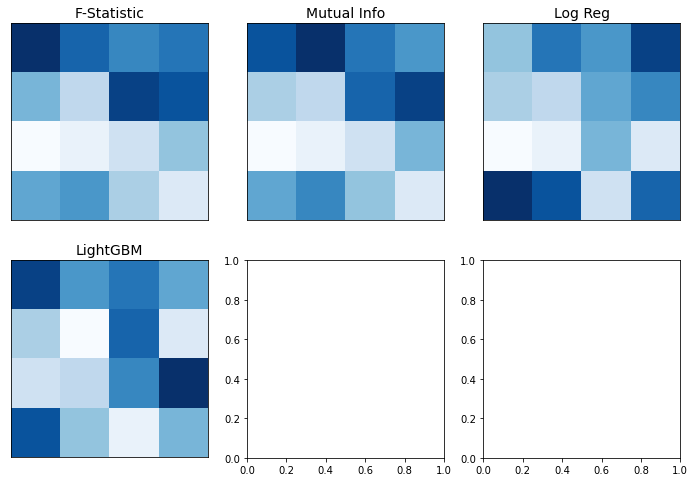

In [28]:
plt_ncols = 3
plt_nrows = 2

fig, axs = plt.subplots(plt_nrows, plt_ncols, figsize = (plt_ncols * 4, plt_nrows * 4))

for e, (algo, title) in enumerate(
    zip(
#         ['f', 'mi', 'logreg', 'boruta'],
#         ['F-Statistic', 'Mutual Info', 'Log Reg', 'Boruta']
        ['f', 'mi', 'logreg', 'lightgbm'],#, 'boruta', 'mrmr'],
        ['F-Statistic', 'Mutual Info', 'Log Reg', 'LightGBM']#,, 'Boruta', 'MRMR']
#         ['f', 'mi', 'logreg', 'lightgbm', 'boruta', 'mrmr'],
#         ['F-Statistic', 'Mutual Info', 'Log Reg', 'LightGBM', 'Boruta', 'MRMR']
    )):

    a = axs[divmod(e, plt_ncols)].imshow(
        ranking[algo].to_numpy().reshape(4, 4), 
#         ranking[algo].to_numpy().reshape(28, 28), 
        cmap = 'Blues_r', 
        vmin = ranking.min().min(), 
        vmax = ranking.max().max()
    )
    
    axs[divmod(e, plt_ncols)].set_title(title, fontsize = 14)
    axs[divmod(e, plt_ncols)].set_xticks([])
    axs[divmod(e, plt_ncols)].set_yticks([])
    
fig.savefig('featimpo_heatmap.png', dpi = 300)

## Predictive Performance on Top Features

In [29]:
# pip install catboost

In [45]:
%%time
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# algos = ['f', 'mi', 'logreg']
algos = ['f', 'mi', 'logreg', 'lightgbm']#, 'mrmr']
# algos = ['f', 'mi', 'logreg', 'lightgbm', 'mrmr']
ks = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]

accuracy = pd.DataFrame(index = ks, columns = algos)
roc = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
    
    for k in ks:
    
        cols = ranking[algo].sort_values().head(k).index.to_list()
                
        clf = CatBoostClassifier().fit(
            X_train[:, cols], y_train,
            eval_set = (X_test[:, cols], y_test),
            early_stopping_rounds = 20,
            verbose = False
        )
                
        accuracy.loc[k, algo] = accuracy_score(
            y_true = y_test, y_pred = clf.predict(X_test[:, cols]))
        roc.loc[k, algo] = roc_auc_score(
            y_true = y_test, y_score = clf.predict_proba(X_test[:, cols]), multi_class = 'ovr', average = 'macro')
        
accuracy.to_csv('accuracy.csv', index = True)
roc.to_csv('roc.csv', index = True)

Wall time: 3min 22s


In [46]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

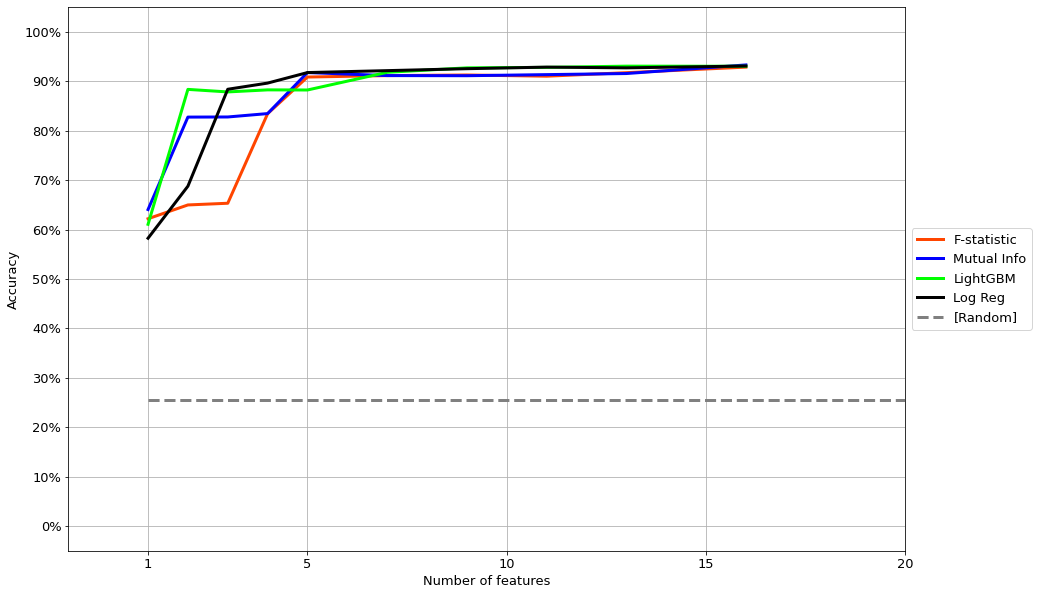

In [47]:
for algo, label, color in zip(
#     ['f', 'mi', 'logreg'],
#     ['F-statistic', 'Mutual Info', 'Log Reg'],
#     ['orangered', 'blue', 'lime']):
    ['f', 'mi', 'lightgbm', 'logreg'],
    ['F-statistic', 'Mutual Info', 'LightGBM', 'Log Reg'],
    ['orangered', 'blue', 'lime', 'black']):
#     ['mrmr', 'f', 'mi', 'lightgbm', 'logreg'],
#     ['MRMR', 'F-statistic', 'Mutual Info', 'LightGBM', 'Log Reg'],
#     ['orangered', 'blue', 'yellow', 'lime', 'black']):
        plt.plot(accuracy.index, accuracy[algo], label = label, color = color, lw = 3)

plt.plot(
    [1, 20], [pd.Series(y_test).value_counts(normalize = True).iloc[0]] * 2, 
    label = '[Random]', color = 'grey', ls = '--', lw = 3
)

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.yticks(np.linspace(0, 1, 11), ['{:.0%}'.format(i) for i in np.linspace(0, 1, 11)], fontsize = 13)
plt.xticks([1] + list(range(5, 21, 5)), fontsize = 13)
plt.xlim(-1, 20)
plt.ylim(-.05, 1.05)
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('Accuracy', fontsize = 13)
plt.savefig('accuracy.png', dpi = 300, bbox_inches = 'tight')

In [48]:
from win32com.client import Dispatch
speak = Dispatch("SAPI.SpVoice").Speak

In [49]:
speak("Complete.")

1